In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

# Funs

In [2]:
def prep_data(sim):
    X = np.stack([eeg.average().data for eeg in sim.eeg_data])
    y = np.stack([src.data for src in sim.source_data])
    for i, (x_sample, y_sample) in enumerate(zip(X, y)):
        # X[i] = np.stack([(x - np.mean(x)) / np.std(x) for x in x_sample.T], axis=0).T
        # y[i] = np.stack([ y / np.max(abs(y)) for y in y_sample.T], axis=0).T

        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] = np.stack([x / np.std(x) for x in x_sample.T], axis=0).T
        
        # X[i] /= np.linalg.norm(X[i])
        y[i] /= np.max(abs(y[i]))

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    
    return X, y
    
def make_mask(y, thresh=0.001):
    y_mask = np.zeros((y.shape[0], y.shape[-1]))
    for i, y_samp in enumerate(y):
        yy = abs(y_samp).mean(axis=0)
        

        y_mask[i] = (yy > yy.max()*thresh).astype(int)
    return y_mask

def get_components(X, leadfield_norm):
    for i, x_sample in enumerate(X):
        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] /= np.linalg.norm(X[i])

    X_components = np.stack([leadfield_norm.T @ X_sample.T for X_sample in X], axis=0)
    X_components = np.swapaxes(X_components, 1, 2)
    X_components = np.stack([XX / np.linalg.norm(XX) for XX in X_components], axis=0)
    return np.abs(X_components)


# Forward

In [3]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulation

In [4]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.01, target_snr=1e99, source_number_weighting=False)


sim = Simulation(fwd, info, settings).simulate(2000)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

# stc.data /= abs(stc.data).max()
# brain = stc.plot(**pp)
# brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
#                font_size=14)
# evoked.plot_joint()

X, y = prep_data(sim)


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
  0%|          | 2/2000 [00:00<06:47,  4.90it/s]c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.

source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2000/2000 [00:04<00:00, 419.22it/s]


# Train

## FC Model

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Dropout
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels, n_dipoles = leadfield.shape
n_time = X.shape[1]

n_dense_units = 300
n_lstm_units = 64
activation_function = "elu"
batch_size = 32
epochs = 50
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC1'))(inputs)

fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC2'))(fc1)

fc3 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC3'))(fc2)


# Masking
# lstm1 = Bidirectional(LSTM(n_lstm_units, return_sequences=False, 
#             input_shape=(None, n_dense_units)), 
#             name='LSTM1')(fc3)
# lstm1 = Dense(n_dipoles, 
#             activation="sigmoid", 
#             name='Mask')(lstm1)

out = TimeDistributed(Dense(n_dipoles, 
            activation="linear", 
            # activity_regularizer=tf.keras.regularizers.L1(l1=0.001),
            name='Output'))(fc3)

# out = multiply([lstm1, out])

model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')
model.compile(loss="mse", optimizer="adam")
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, min_delta=0.00, monitor="val_loss", restore_best_weights=True)]
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)


Model: "Prelocalizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 128)]       0         
                                                                 
 time_distributed_7 (TimeDis  (None, None, 300)        38700     
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 300)        90300     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, None, 300)        90300     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1284)       386484    
 stributed)                                           

## LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Dropout, Activation
from tensorflow.keras import backend as K

n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 150
activation_function = "elu"
batch_size = 32
epochs = 40
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')


fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC1'))(inputs)

fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC2'))(fc1)

lstm1 = LSTM(n_lstm_units, return_sequences=True, name='LSTM1')(fc2)

out = TimeDistributed(Dense(n_dipoles, 
            activation="linear", 
            # activity_regularizer=tf.keras.regularizers.L1(l1=0.0001),
            name='Mask'))(lstm1)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')
model.compile(loss="mse", optimizer="adam")
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.00, monitor="val_loss", restore_best_weights=True)]

model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)
# model.fit(X[:, 0], y_mask, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Prelocalizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 128)]       0         
                                                                 
 time_distributed_4 (TimeDis  (None, None, 300)        38700     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 300)        90300     
 tributed)                                                       
                                                                 
 LSTM1 (LSTM)                (None, None, 150)         270600    
                                                                 
 time_distributed_6 (TimeDis  (None, None, 1284)       193884    
 tributed)                                                       
                                                      

# Eval raw

In [112]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=2, extents=25, duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
X_test, y_test = prep_data(sim_test)

y_hat = model.predict(X_test)


# y_hat = model.predict(X_test[:, 0])

plt.figure()
plt.plot(np.linalg.norm(y_hat[0], axis=0))

# plt.figure()
plt.plot(np.linalg.norm(y[0], axis=0))
print(pearsonr(np.linalg.norm(y_hat[0], axis=0), np.linalg.norm(y[0], axis=0)))

stc = sim_test.source_data[0]

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc.data = y_hat[0].T
stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Pred', 'title',
               font_size=14)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 286.51it/s]


1/1 [==============================] - 0s 71ms/step
(-0.0016119901181370839, 0.9539827077001574)
Using control points [0. 0. 1.]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Using control points [0.17132007 0.22174371 0.83193327]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# LSTM Matching Pursuit

In [144]:
settings = dict(number_of_sources=2, extents=(24, 25), duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
stc = sim_test.source_data[0]
evoked = sim_test.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X_test_norm, y_test_norm = prep_data(sim_test)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 286.48it/s]

Using control points [0.         0.         0.58415545]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


[881]
3.940616749900905e-05
0  Res var:  61.757797902994795
[809 881]
3.38790317743624e-05
1  Res var:  45.64838154334141
[809 812 881]
2.6260338403016274e-05
2  Res var:  27.426099077058332
[691 809 812 881]
1.9828726425979635e-05
3  Res var:  15.636985943892569
[ 691  809  812  881 1019]
1.3435756606897396e-05
4  Res var:  7.179391882337377
[ 691  809  812  881 1019 1127]
1.2673002996994638e-05
5  Res var:  6.387375955223728
[ 691  809  812  881 1019 1126 1127]
8.607058246583879e-06
6  Res var:  2.946272335498863
[ 691  809  812  881 1019 1023 1126 1127]
7.448761243081567e-06
7  Res var:  2.2066401292341866
[ 691  809  812  881 1019 1021 1023 1126 1127]
7.372195599023093e-06
8  Res var:  2.1615092715944133
[ 691  809  812  836  881 1019 1021 1023 1126 1127]
6.346804647114344e-06
9  Res var:  1.6020411458916315
[ 691  783  809  812  836  881 1019 1021 1023 1126 1127]
5.591859966632828e-06
10  Res var:  1.2435864408683661
[ 691  783  809  812  836  881 1017 1019 1021 1023 1126 1127]
5.

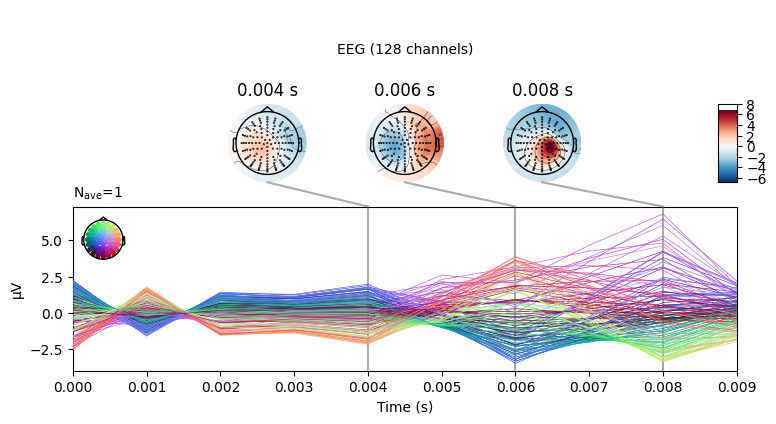

In [153]:
from scipy.stats import pearsonr
from invert.util import find_corner, calc_residual_variance
max_iter = 25
K = 1
X_test = evoked.data
X_test -= X_test.mean(axis=0)

# dimensions
n_chans, n_dipoles = leadfield.shape
n_time = X_test.shape[-1]

# Predict Gammas
if len(X_test.shape) == 3:
    X_test = X_test[0]

# get initial orthogonal leadfield components
R = deepcopy(X_test_norm[0].T)
rescale_norms = X_test.std(axis=0)
# rescale_norms = np.ones(10)

residual_norms = [1e99,]
idc = np.array([])
for i in range(max_iter):

    y_hat_model = model.predict(R.T[np.newaxis], verbose=0)[0]
    # y_hat_model = (y_hat_model.T * rescale_norms).T
    stc_.data = y_hat_model.T
    # stc_.plot(**pp)
    gammas = np.linalg.norm(y_hat_model, axis=0)
    gammas /= gammas.max()
    
    mp = (leadfield_norm.T @ R) / np.linalg.norm(R)
    # mp *= rescale_norms
    gammas_mp = np.linalg.norm(mp, axis=1)

    # gammas_mp /= gammas_mp.max()
    # gammas_mp = gammas_mp**2

    stc_ = stc.copy()
    stc_.data[:,0] = gammas
    stc_.data[:,1] = gammas_mp

    # print("max: ", gammas_mp.max())
    # if gammas_mp.max() > 0.99:
    #     gammas = gammas_mp
    # else:
    #     gammas = gammas * gammas_mp
    
    stc_.data[:,2] = gammas

    
    # stc_.plot(**pp)

    # gammas = gammas_mp

    # plt.figure()
    # plt.plot(gammas)


    idx = np.argsort(gammas)[-K:]

    arg_sorted = np.argsort(gammas)[::-1]
    ii = 0
    idx = arg_sorted[ii]
    while idx in idc:
        ii += 1
        idx = arg_sorted[ii]

    idc = np.unique(np.append(idc, idx)).astype(int)
    print(idc)

    # Inversion Scheme 1
    leadfield_pinv = np.linalg.pinv(leadfield[:, idc])
    y_hat = np.zeros((n_dipoles, n_time))
    y_hat[idc] = leadfield_pinv @ X_test
    
    # Inversion Scheme 2
    # gammas = np.zeros(n_dipoles)
    # gammas[idc] = 1
    # y_hat = np.diag(gammas) @ leadfield.T @ X_test

    X_hat = leadfield @ y_hat
    # Rereference predicted EEG
    X_hat -= X_hat.mean(axis=0)
    
    # Calculate Residual
    R = X_test - X_hat
    # R = X_test / X_test.std(axis=0) - X_hat / X_hat.std(axis=0)
    
    # Rereference and scale predicted Residual
    R -= R.mean(axis=0)

    
    residual_norm = np.linalg.norm(R)
    residual_norms.append( residual_norm )
    
    rescale_norms = R.std(axis=0)
    # rescale_norms = np.ones(10)

    R /= rescale_norms
    rescale_norms /= rescale_norms.mean()

    # print(idc)
    print(residual_norm)
    rv = calc_residual_variance(X_hat, X_test)
    print(i, " Res var: ", rv)
    # break

    # plt.figure()
    # plt.subplot(311)
    # im, _ = mne.viz.plot_topomap(np.linalg.norm(X_test, axis=1), info)
    # # im, _ = mne.viz.plot_topomap(X_test_norm[0, 0, :], info)
    # plt.colorbar(im)
    # plt.title("True")
    # plt.subplot(312)
    # im, _ = mne.viz.plot_topomap(np.linalg.norm(X_hat, axis=1), info)
    # # im, _ = mne.viz.plot_topomap(X_hat[:, 0], info)
    
    # plt.colorbar(im)
    # plt.title("Current X_hat")
    # plt.subplot(313)
    # im, _ = mne.viz.plot_topomap(np.linalg.norm(R, axis=1), info)
    # # im, _ = mne.viz.plot_topomap(R[:, 0], info)
    # plt.colorbar(im)
    # plt.title("Residual")

    # if residual_norms[-1] >= residual_norms[-2] or rv<1:
    if rv<0.1:
    
        break
    
X_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(X_hat, info)
evoked_.plot_joint()


Using control points [0.         0.         0.55483579]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


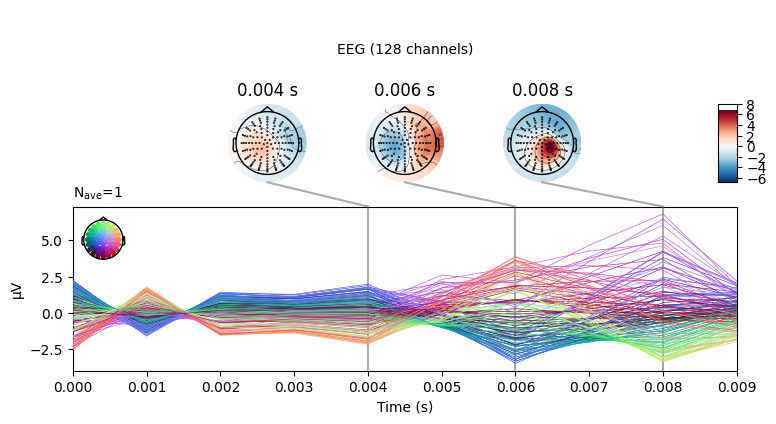

Using control points [0.         0.         0.65707901]
Using control points [0.         0.         0.65707901]


In [154]:
stc_ = stc.copy()
stc_.data = y_hat / abs(y_hat).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Pred', 'title',
               font_size=14)

x_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(x_hat, info)
evoked_.plot_joint()